In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt

def readh5(fn):
        f = h5py.File(fn, "r")
        data = f["dataset_0"][:]
        f.close
        return data

# Load, process data

In [2]:
# load data
x_data_raw = readh5('xdata.h5')
y_data_raw = readh5('ydata.h5')

def norm(dt:np.ndarray):
    maxx = np.max(dt)
    minn = np.min(dt)
    print(f"max is {maxx}, min is {minn}")
    output = torch.from_numpy((dt - minn)/(maxx-minn))
    return output.reshape(-1,1).float()

# Normalize data
# See https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93 to avoid leakage
x_data = torch.cat((norm(x_data_raw[:,0]), norm(x_data_raw[:,1]), norm(x_data_raw[:,2])), axis=1)
y_data = torch.cat((norm(y_data_raw[:,0]), norm(y_data_raw[:,1]), norm(y_data_raw[:,2]), norm(y_data_raw[:,3])), axis=1)

# split data
n = len(x_data)
x_train, x_val, x_test = x_data[:int(n*0.7)], x_data[int(n*0.7):int(n*0.9)], x_data[int(n*0.9):]
y_train, y_val, y_test = y_data[:int(n*0.7)], y_data[int(n*0.7):int(n*0.9)], y_data[int(n*0.9):]
print(x_train.shape)

train_dtset = TensorDataset(x_train, y_train)
val_dtset = TensorDataset(x_val, y_val)
print(train_dtset.tensors)

batch_size=64 # typically 64, 128,256, 512 are used depending on training data size
train_dtloader = DataLoader(train_dtset,batch_size=batch_size, shuffle=True)
val_dtloader = DataLoader(val_dtset,batch_size=batch_size, shuffle=True)

for X, y in train_dtloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

max is 1499.9779917661701, min is 27.023874271037144
max is 1.4999582584225648, min is 0.30003352763833974
max is 5.999803174931337, min is 0.00011375924833734175
max is 1.247913465538515, min is 0.0026104519608322538
max is 6.48918846168899, min is 0.011923575925976244
max is 3.604024701138167, min is 0.010933638549284103
max is 18.65603391399858, min is 0.04822045709274274
torch.Size([13861, 3])
(tensor([[0.2051, 0.2436, 0.7807],
        [0.9118, 0.4685, 0.8793],
        [0.1313, 0.2478, 0.3042],
        ...,
        [0.5053, 0.8142, 0.4130],
        [0.4886, 0.3676, 0.7911],
        [0.9787, 0.2231, 0.1963]]), tensor([[0.2132, 0.2465, 0.2157, 0.2519],
        [0.4618, 0.4917, 0.5322, 0.5685],
        [0.0700, 0.0069, 0.0709, 0.0047],
        ...,
        [0.0517, 0.0974, 0.0526, 0.0873],
        [0.2869, 0.3281, 0.3106, 0.3578],
        [0.1330, 0.0285, 0.1739, 0.0387]]))
Shape of X [N, C, H, W]: torch.Size([64, 3])
Shape of y: torch.Size([64, 4]) torch.float32


# Creating models

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 512),
            nn.ReLU(), # ReLU is rule of thumb choice
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)


# Model parameters

In [4]:
#loss_fn = nn.CrossEntropyLoss() # for classification
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# SGD with momentum 0.9 - https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
# adam optimizer with L2 regularization (weight_decay = 1e-5)
# scheduler = ExponentialLR(optimizer, gamma=0.9) # learning_rate scheduler (decaying learning rate over epoch)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            #accuracy = Accuracy()
    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n  Avg loss: {test_loss:>8f} \n")
    return test_loss

In [5]:
epochs = 600
epoch_arr = []
loss_arr = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dtloader, model, loss_fn, optimizer)
    # scheduler.step() # decay learning_rate every epoch
    test_loss = test(val_dtloader, model, loss_fn)
    epoch_arr.append(t)
    loss_arr.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.049620  [    0/13861]
loss: 0.032017  [ 6400/13861]
loss: 0.033781  [12800/13861]
Test Error: 
  Avg loss: 0.028560 

Epoch 2
-------------------------------
loss: 0.020030  [    0/13861]
loss: 0.028928  [ 6400/13861]
loss: 0.021047  [12800/13861]
Test Error: 
  Avg loss: 0.025400 

Epoch 3
-------------------------------
loss: 0.026835  [    0/13861]
loss: 0.020557  [ 6400/13861]
loss: 0.018979  [12800/13861]
Test Error: 
  Avg loss: 0.023605 

Epoch 4
-------------------------------
loss: 0.019953  [    0/13861]
loss: 0.023504  [ 6400/13861]
loss: 0.027167  [12800/13861]
Test Error: 
  Avg loss: 0.022124 

Epoch 5
-------------------------------
loss: 0.026094  [    0/13861]
loss: 0.024571  [ 6400/13861]
loss: 0.026109  [12800/13861]
Test Error: 
  Avg loss: 0.020834 

Epoch 6
-------------------------------
loss: 0.016682  [    0/13861]
loss: 0.017183  [ 6400/13861]
loss: 0.020722  [12800/13861]
Test Error: 
  Avg loss: 0.019711 

Epoc

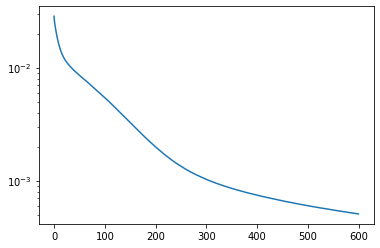

In [6]:
plt.plot(epoch_arr,loss_arr)
plt.yscale("log")

In [7]:
predicted = model(x_test)
print(predicted)
print(y_test)
print(loss_fn(y_test,predicted))

tensor([[0.5212, 0.5833, 0.4495, 0.5104],
        [0.1956, 0.0319, 0.1849, 0.0322],
        [0.2094, 0.2937, 0.1920, 0.2645],
        ...,
        [0.2877, 0.3604, 0.3269, 0.4020],
        [0.1973, 0.2846, 0.1633, 0.2456],
        [0.2380, 0.2983, 0.2159, 0.2633]], grad_fn=<AddmmBackward0>)
tensor([[0.5225, 0.5882, 0.4529, 0.5114],
        [0.2086, 0.0557, 0.1814, 0.0504],
        [0.2147, 0.3010, 0.1998, 0.2829],
        ...,
        [0.2914, 0.3672, 0.3191, 0.4041],
        [0.1754, 0.2882, 0.1555, 0.2589],
        [0.2541, 0.3069, 0.2332, 0.2841]])
tensor(0.0005, grad_fn=<MseLossBackward0>)


In [8]:
import time

t = time.time()
model(x_test[:1])
print(f"time elapsed: {time.time()-t}")

time elapsed: 0.002403736114501953
